# 1.Setup

Import the required packages

In [20]:
import numpy as np
from numpy import mean

import torch.nn as nn
import torch

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import torchvision
from matplotlib import pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sn


#  2Model structure construction
## 2.1Densenet


REF:huang, g., 2021. GitHub - liuzhuang13/DenseNet: Densely Connected Convolutional Networks, In CVPR 2017 (Best Paper Award).. [online] GitHub. Available at: <https://github.com/liuzhuang13/DenseNet> [Accessed 8 November 2021].

In [21]:
#Construct denseblock.
class DenseBlock(nn.Module):
    def __init__(self,inchannel,outchannel):
        super(DenseBlock, self).__init__()
        interChannels=4*outchannel
        
        
        self.Block1=nn.Sequential(
            nn.BatchNorm2d(inchannel),
            nn.Conv2d(inchannel,interChannels,kernel_size=(1,1),bias=False),
            nn.CELU()
        )

        self.Block2=nn.Sequential(
            nn.BatchNorm2d(interChannels),
            nn.Conv2d(interChannels,outchannel,kernel_size=(3,3), padding=1,bias=False),
            nn.CELU()
        )

    def forward(self,x):
        out=self.Block1(x)
        out=self.Block2(out)
        #Construct the output of each DenseBlock through concat.
        #The input of the current layer through concat can be passed to all the blocks of the current DenseBlock group.
        out=torch.cat((x,out),1)
        return out

class Transition(nn.Module):
    def __init__(self,inchannel,outchannels):
        super(Transition, self).__init__()
        self.tran=nn.Sequential(
            nn.AvgPool2d((2,2)),
            nn.BatchNorm2d(inchannel),
            nn.CELU(),
            nn.Conv2d(inchannel,outchannels,kernel_size=(1,1),bias=False),

        )

    def forward(self,x):
        out=self.tran(x)
        return out
    
class DenseNet(nn.Module):
    def __init__(self, k, depth, reduction):
        super().__init__()
        nDenseBlocks=(depth-4)//6

        denseChannels=2*k
        
        #Input layer
        self.conv1 = nn.Conv2d(3,denseChannels, kernel_size=3, padding=1,
                               bias=False)
        self.dense1 = self.make_denseblock(denseChannels, k, nDenseBlocks)
        #The number of channels output by DenseBlock.
        denseChannels+= nDenseBlocks * k
        # Set the number of channels of the feature map output 
        #   by Transition according to the channel reduction ratio set by the parameter reduction.
        tran_out_chnnel = int(math.floor(denseChannels * reduction))
        self.trans1 = Transition(denseChannels, tran_out_chnnel)
        denseChannels = tran_out_chnnel
        
        self.dense2 = self.make_denseblock(denseChannels, k, nDenseBlocks)
        denseChannels+= nDenseBlocks * k
        nOutChannels = int(math.floor(denseChannels * reduction))
        self.trans2 = Transition(denseChannels, nOutChannels)
        denseChannels = nOutChannels

        self.dense3 = self.make_denseblock(denseChannels, k, nDenseBlocks)
        denseChannels += nDenseBlocks * k
        
        #Output layer
        self.classifer=nn.Sequential(
            #The Drop layer is used to reduce overfitting.
            nn.Dropout(0.5),
            nn.BatchNorm2d(denseChannels),
            #Activation function
            nn.CELU(),
            #Max pooling
            nn.MaxPool2d((8,8),2)
        )
        self.fc=nn.Linear(denseChannels,100)


    def make_denseblock(self,inchannels,outchannel,num_blocks):
        blocks=[]
        #Call the defined dense block to construct the model in a cyclic manner.
        for i in range(int(num_blocks)):
            blocks.append(DenseBlock(inchannels,outchannel))
            inchannels+=outchannel
        return nn.Sequential(*blocks)

    def forward(self, x):
        out = self.conv1(x)
        out = self.trans1(self.dense1(out))
        out = self.trans2(self.dense2(out))
        out = self.dense3(out)
        out=self.classifer(out)
        #Turn the two-dimensional feature map output by the convolutional layer into one-dimensional and output it to the fully connected layer for classification.
        out = out.view(out.size(0), -1)
        out= self.fc(out)

        return out


## 2.2 Resnet

REF：GitHub. 2021. vision/resnet.py at 6db1569c89094cf23f3bc41f79275c45e9fcb3f3 · pytorch/vision. [online] Available at: <https://github.com/pytorch/vision/blob/6db1569c89094cf23f3bc41f79275c45e9fcb3f3/torchvision/models/resnet.py#L124> [Accessed 8 November 2021].

In [22]:
class BuildingBlock(nn.Module):
    def __init__(self, in_channel, out_channel, stride=1):
        super(BuildingBlock,self).__init__()
        self.stride=stride
        #Convolution module
        self.convPart=nn.Sequential(
            nn.Conv2d(in_channel,
                      out_channel,
                      kernel_size=3,
                      stride=stride,
                      padding=1,
                      bias=False), nn.BatchNorm2d(out_channel),
            #Activation function
            nn.CELU(inplace=True),
            nn.Conv2d(out_channel,
                      out_channel,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(out_channel),
        )
        
        self.Residual_link = nn.Sequential()
        #Residual link
        #The step size is not 1, which means that the current block is the first layer of each stage, 
        #     and a convolution kernel with a step size of 2 is used. This will cause the number of 
        #      output channels of the convolutional layer and the number of channels of the residual link to be unequal.
        
        if stride != 1 or in_channel != out_channel:
            self.Residual_link= nn.Sequential(
                nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channel)
            )
        self.activate = nn.CELU(inplace=True)
    def forward(self, x):
        out = self.convPart(x)
        residual = self.Residual_link(x)
        out += residual
        out = self.activate(out)
        return out



class ResNet18(nn.Module):
    def __init__(self,Block, expansion = 1):
        super(ResNet18, self).__init__()
        self.input=nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=64,kernel_size=(3,3),padding=1,bias=False),
            nn.BatchNorm2d(64),
            nn.CELU(inplace=True),
        )
        #Build a network structure
        self.stage1=self.makestage(Block,inchannel=64,outchannel=64,num_block=2,stride=1)
        self.stage2 = self.makestage(Block,inchannel=64, outchannel=128, num_block=2, stride=2)
        self.stage3= self.makestage(Block,inchannel=128, outchannel=256, num_block=2, stride=2)
        self.stage4 = self.makestage(Block,inchannel=256, outchannel=512, num_block=2, stride=2)
        #The dimension on each channel is 1x1
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dp = nn.Dropout(0.5)
        #Fully connected layer for classification
        self.fc = nn.Linear(512, 100)

    def makestage(self,Block,num_block,inchannel,outchannel,stride,exp=1):
        blocks=[]
        blocks.append(Block(inchannel,outchannel,stride=stride))
        for i in range(1,num_block):
            blocks.append(Block(outchannel,outchannel))

        return nn.Sequential(*blocks)



    def forward(self,x):
        out=self.input(x)
        out=self.stage1(out)
        out= self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)
        out = self.avgpool(out)
        out = out.view(x.size(0), -1)
        out=self.dp(out)
        out= self.fc(out)

        return out

## 2.3 VGG


In [23]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()

        self.convblocks1= self.make_layer(2,64,3)
        self.convblocks2 = self.make_layer(2, 128,64)
        self.convblocks3 = self.make_layer(4, 256,128)
        self.convblocks4 = self.make_layer(4, 512,256)
        self.convblocks5 = self.make_layer(4, 512,512)
        self.pooling=nn.AdaptiveAvgPool2d((7, 7))
        self.classifer = nn.Sequential(
            # inchannl= 512*7*7
            nn.Linear(25088, 4096),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 100),
        )


    def make_layer(self,n_layers,channels,in_channels):
        layer=[]
        layer.append(nn.Conv2d(in_channels=in_channels, out_channels=channels, kernel_size=3,padding=1,bias=False))
        layer.append(nn.ReLU(inplace=True))
        for i in range(1,n_layers):
            layer.append(nn.Conv2d(channels,channels,kernel_size=3,padding=1,bias=False))
            if(i==n_layers-1):
                layer.append(nn.BatchNorm2d(channels))
            layer.append(nn.ReLU(inplace=True))
        layer.append(nn.MaxPool2d(kernel_size=2,stride=2))
        return nn.Sequential(*layer)

    def forward(self, x):
        out=  self.convblocks1(x)
        out = self.convblocks2(out)
        out = self.convblocks3(out)
        out = self.convblocks4(out)
        out = self.convblocks5(out)
        out= self.pooling(out)
        out = out.view(x.size(0), -1)
        out= self.classifer(out)
        return out


#  3 Data set loading and preprocessing

## 3.1 Set the data preprocessing step.

In [24]:
train_transform = transforms.Compose([
    
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor(),
    #Normalized
    transforms.Normalize(
            np.array([125.3, 123.0, 113.9]) / 255.0,
            np.array([63.0, 62.1, 66.7]) / 255.0),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    #Normalized
    transforms.Normalize(
            np.array([125.3, 123.0, 113.9]) / 255.0,
            np.array([63.0, 62.1, 66.7]) / 255.0),
])

## 3.2 Load data set

Read the training set and test set separately

In [25]:
train_dataset = torchvision.datasets.CIFAR100(root='/data',
                                                ##Training set
                                               train=True,
                                               transform=train_transform,
                                               download=True,
                                               )

test_dataset = torchvision.datasets.CIFAR100(root='/data',
                                              ##Testing set
                                              train=False,
                                              transform=test_transform,
                                              download=True
                                              )

Files already downloaded and verified
Files already downloaded and verified


Divide the training set loaded in the previous step into a training set and a validation set.

* In this experiment, 45,000 pictures were selected as the training set, and 5,000 pictures were used as the validation set. 

In [26]:
#Set the validation set ratio
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
#Randomly divide the data set
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])


## 3.3 Group each data set into a minibatch.

In [27]:
#Set the batchsize size.
batch_size=128
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    #Shuffle the data set
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    #Shuffle the data set
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    #Shuffle the data set
    shuffle=True)

#  4 Training and testing

## 4.1 Test method definition

In [28]:
#Select the model to be trained.

In [29]:
def eval(model,data,Test_Var,Result):
    model.eval()

    with torch.no_grad():
        correct = 0
        total = 0
        all_preds = torch.tensor([])
        all_labels = torch.tensor([])
        for images, labels in data:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds = torch.cat(
                (all_preds, predicted.data.cpu())
                , dim=0
            )
            all_labels = torch.cat(
                (all_labels, labels.data.cpu())
                , dim=0
            )
        if(Result==True):
            con = confusion_matrix(np.array(all_labels).astype(int), np.array(all_preds).astype(int))
            sn.heatmap(con, cmap='Purples')
            plt.show()
            print("Accuracy of the model on the "+Test_Var+" dataset:{}%".format(100 * correct / total))
            cr=classification_report(np.array(all_labels).astype(int), np.array(all_preds).astype(int),target_names=test_dataset.classes,digits=4)
            print(cr)
    return 100 * correct / total


## 4.2 Train method definition

In [30]:
def train(model,num_epochs,train_loader,criterion,scheduler,optimizer,savepath=None):
    loss_list=[]
    val_list=[]
    loss=0
    for epoch in tqdm(range(num_epochs)):
        model.train()
        loss=0
        loss_batch_list = []
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_list.append(loss.item())
        #print("Epoch[{}/{}] Loss: {:.4f}".format(epoch + 1, num_epochs, loss.item()))
        val_acc=eval(model,val_loader,"Var",False)
        val_list.append(val_acc)
        if (epoch + 1) % 10 == 0:
            test_acc=eval(model, test_loader, "Test",False)
        scheduler.step()
    print("Loss in train dataset"+str(loss_list[-1]))
    print("Accuracy of the model on the "+"Test"+" dataset:{}%".format(eval(model, test_loader, "Test",False)))
    x = range(num_epochs)
    #
    fig = plt.figure()
    a1 = fig.add_subplot(111)
    a1.plot(x,loss_list)
    a1.set_ylabel('loss')
    a2 = a1.twinx()
    a2.plot(x, val_list, 'r')
    a2.set_ylabel('val acc')
    fig.legend(labels=('loss', 'val acc'), loc='upper left')
    plt.show()
    torch.save(model,savepath)

## 4.3 Train and test VGG19

True


100%|██████████| 150/150 [39:51<00:00, 15.94s/it]


Loss in train dataset0.10022267699241638
Accuracy of the model on the Test dataset:64.8%


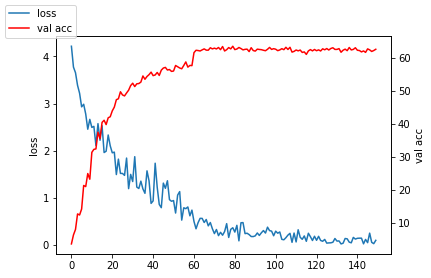

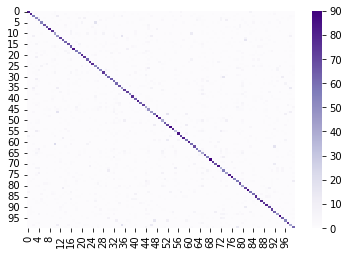

Accuracy of the model on the Test dataset:64.8%
               precision    recall  f1-score   support

        apple     0.8632    0.8200    0.8410       100
aquarium_fish     0.8778    0.7900    0.8316       100
         baby     0.5545    0.5600    0.5572       100
         bear     0.3586    0.5200    0.4245       100
       beaver     0.3906    0.5000    0.4386       100
          bed     0.7105    0.5400    0.6136       100
          bee     0.7444    0.6700    0.7053       100
       beetle     0.7053    0.6700    0.6872       100
      bicycle     0.9011    0.8200    0.8586       100
       bottle     0.7500    0.7500    0.7500       100
         bowl     0.3839    0.4300    0.4057       100
          boy     0.4312    0.4700    0.4498       100
       bridge     0.6923    0.7200    0.7059       100
          bus     0.6701    0.6500    0.6599       100
    butterfly     0.5980    0.6100    0.6040       100
        camel     0.6239    0.6800    0.6507       100
          can   

64.8

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
#Create model
model=VGG()
#Number of training iterations
num_epochs=150
model.cuda()
#Learning rate
learning_rate=0.01
# optimizer=torch.optim.Adam(model.parameters(),lr=0.0001)
optimizer = torch.optim.SGD(model.parameters(),
                lr=learning_rate,
                momentum=0.9,
                weight_decay=0.0001,
                nesterov=True)

#Set the learning rate drop rule.
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [60,120],gamma=0.1)
#Set loss function
criterion= nn.CrossEntropyLoss().cuda()
train(model,num_epochs,train_loader,criterion,scheduler,optimizer,"VGG19.h5")
eval(model, test_loader, "Test",True)


## 4.4 Train and test Resnet18

True


100%|██████████| 150/150 [45:21<00:00, 18.14s/it]


Loss in train dataset0.11181989312171936
Accuracy of the model on the Test dataset:72.29%


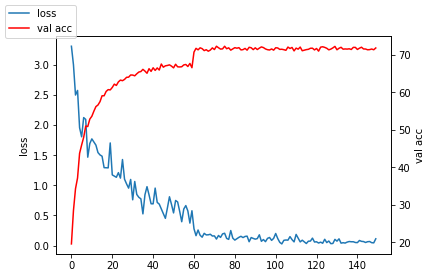

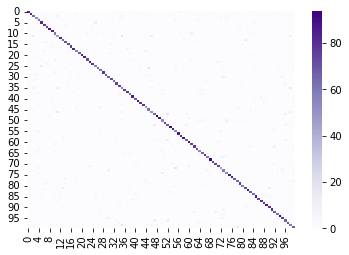

Accuracy of the model on the Test dataset:72.29%
               precision    recall  f1-score   support

        apple     0.8842    0.8400    0.8615       100
aquarium_fish     0.9032    0.8400    0.8705       100
         baby     0.6300    0.6300    0.6300       100
         bear     0.5000    0.5300    0.5146       100
       beaver     0.5439    0.6200    0.5794       100
          bed     0.7523    0.8200    0.7847       100
          bee     0.6814    0.7700    0.7230       100
       beetle     0.7228    0.7300    0.7264       100
      bicycle     0.8544    0.8800    0.8670       100
       bottle     0.8000    0.8400    0.8195       100
         bowl     0.5941    0.6000    0.5970       100
          boy     0.4945    0.4500    0.4712       100
       bridge     0.7905    0.8300    0.8098       100
          bus     0.7065    0.6500    0.6771       100
    butterfly     0.7071    0.7000    0.7035       100
        camel     0.7374    0.7300    0.7337       100
          can  

72.29

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
#Create model
model=ResNet18(BuildingBlock)
#Number of training iterations
num_epochs=150
model.cuda()
#Learning rate
learning_rate=0.01

optimizer = torch.optim.SGD(model.parameters(),
                lr=learning_rate,
                momentum=0.9,
                weight_decay=0.0001,
                nesterov=True)

#Set the learning rate drop rule.
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [60,120],gamma=0.1)
#Set loss function
criterion= nn.CrossEntropyLoss().cuda()
train(model,num_epochs,train_loader,criterion,scheduler,optimizer,"Resnet18.h5")
eval(model, test_loader, "Test",True)

## 4.5 Train and test DenseNet BC 100

True


100%|██████████| 150/150 [1:37:58<00:00, 39.19s/it]


Loss in train dataset0.13762874901294708
Accuracy of the model on the Test dataset:68.08%


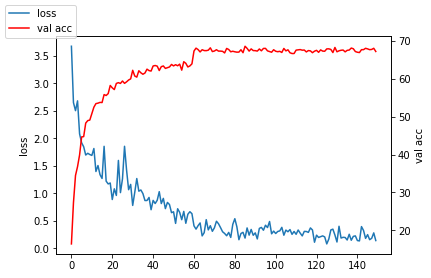

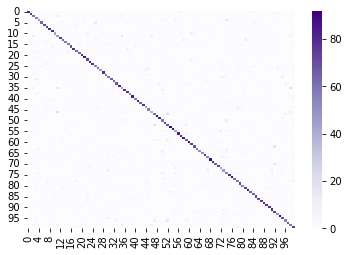

Accuracy of the model on the Test dataset:68.08%
               precision    recall  f1-score   support

        apple     0.9101    0.8100    0.8571       100
aquarium_fish     0.7451    0.7600    0.7525       100
         baby     0.5842    0.5900    0.5871       100
         bear     0.4622    0.5500    0.5023       100
       beaver     0.4787    0.4500    0.4639       100
          bed     0.8000    0.6400    0.7111       100
          bee     0.7273    0.7200    0.7236       100
       beetle     0.6016    0.7400    0.6637       100
      bicycle     0.8778    0.7900    0.8316       100
       bottle     0.6667    0.8000    0.7273       100
         bowl     0.5584    0.4300    0.4859       100
          boy     0.4182    0.4600    0.4381       100
       bridge     0.7600    0.7600    0.7600       100
          bus     0.6458    0.6200    0.6327       100
    butterfly     0.7073    0.5800    0.6374       100
        camel     0.6705    0.5900    0.6277       100
          can  

68.08

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
#Create model
model=DenseNet(12,100,0.5)
#Number of training iterations
num_epochs=150
#Load the model to the graphics card.
model.cuda()
#Learning rate
learning_rate=0.01

optimizer = torch.optim.SGD(model.parameters(),
                lr=learning_rate,
                momentum=0.9,
                weight_decay=0.0001,
                nesterov=True)

#Set the learning rate drop rule.
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,[60,120],gamma=0.1)
#Set loss function
criterion= nn.CrossEntropyLoss().cuda()
train(model,num_epochs,train_loader,criterion,scheduler,optimizer,"DenseNetBC100.h5")
eval(model, test_loader, "Test",True)